# QTT representation of a Pair Propagator

This notebook demonstrates how a pair propagator function can be approximated with a QTT representation. The pair propagator is defined as
$$ \Pi_0^\Lambda(\omega, \nu) ~=~ - G_0^\Lambda(\nu + \tfrac{\omega}{2}) ~ G_0^\Lambda(\nu - \tfrac{\omega}{2}) $$
$$ G_0^\Lambda(\nu) ~=~ \frac{-i\nu}{\nu^2 + \Lambda^2}, $$
which corresponds to a bare pair propagator in pseudofermion fRG as a simple example with a mixture of highly structured and flat regions.

In [1]:
# Put the path to xfac here
ENV["PYTHONPATH"] = "/Users/Ritter.Marc/src/xfac/python/"

using QuanticsTCI
using ITensors
using PyPlot

# Parameters
Lambda = 1.0
n = 12
npoints = 2^n
freqmax = 100
freqs = range(-freqmax, freqmax, npoints)

function index_to_frequency(index)
    return (2 * index / npoints - 1) * freqmax
end

function pairpropagator(omegaindex, nuindex)
    omega, nu = index_to_frequency.([omegaindex, nuindex])
    return QuanticsTCI.G0(Lambda, nu - omega / 2) *
           QuanticsTCI.G0(Lambda, nu + omega / 2)
end

# Get a tensor train representation of the pairpropagator

p0 = Int(floor(npoints * (1 / freqmax + 1) / 2))
firstpivot = index_to_quantics([1, p0], n)

pairpropagator_qtt, ranks, errors = QuanticsTCI.qtt(
    indices -> pairpropagator(quantics_to_index(indices .+ 1, d=2)...),
    4,
    firstpivot;
    cutoff=1e-5, maxiter=200
)

# Put this representation into an ITensor MPS

combined_indices = [Index(4, "site") for i in 1:n]
pairpropagator_qttmps = QuanticsTCI.qtt_to_mps(
    pairpropagator_qtt, combined_indices)

print(pairpropagator_qttmps)

10	10	206.49033168735315
20	20	33.662300818515156
30	30	3.6302462741253168
40	40	0.10492868523399697
50	50	0.006950741944552345
60	60	0.0005095463350993424
70	70	9.111399010295689e-5
80	80	1.1049561268112188e-5
MPS
[1] ((dim=4|id=221|"site"), (dim=4|id=955|"link"))
[2] ((dim=4|id=955|"link"), (dim=4|id=605|"site"), (dim=16|id=855|"link"))
[3] ((dim=16|id=855|"link"), (dim=4|id=284|"site"), (dim=64|id=748|"link"))
[4] ((dim=64|id=748|"link"), (dim=4|id=712|"site"), (dim=82|id=978|"link"))
[5] ((dim=82|id=978|"link"), (dim=4|id=150|"site"), (dim=82|id=36|"link"))
[6] ((dim=82|id=36|"link"), (dim=4|id=542|"site"), (dim=82|id=994|"link"))
[7] ((dim=82|id=994|"link"), (dim=4|id=216|"site"), (dim=82|id=621|"link"))
[8] ((dim=82|id=621|"link"), (dim=4|id=903|"site"), (dim=82|id=495|"link"))
[9] ((dim=82|id=495|"link"), (dim=4|id=510|"site"), (dim=64|id=409|"link"))
[10] ((dim=64|id=409|"link"), (dim=4|id=437|"site"), (dim=16|id=17|"link"))
[11] ((dim=16|id=17|"link"), (dim=4|id=990|"site"), (

┌ Info: Precompiling QuanticsTCI [b11687fd-3a1c-4c41-97d0-998ab401d50e]
└ @ Base loading.jl:1423


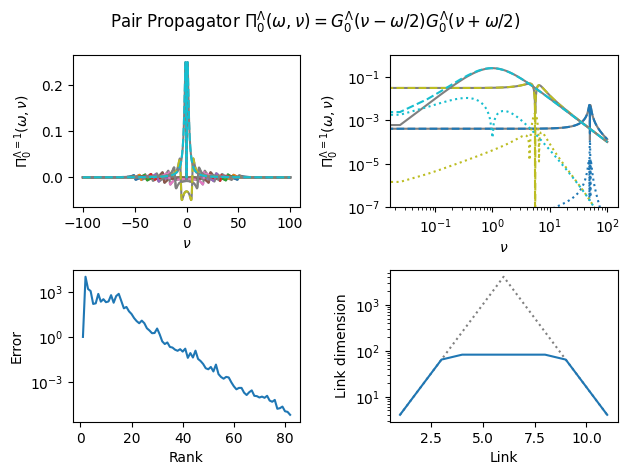

In [2]:
# Plot everything.

fig, axs = subplots(2, 2)
fig.suptitle(
    L"Pair Propagator $\Pi_0^\Lambda(\omega, \nu) = G_0^\Lambda(\nu - \omega/2) G_0^\Lambda(\nu + \omega/2)$")

# Slices through the result, to compare whether the tensor train really gives
# a good approximation.

offsets = Int.(trunc.(range(1, div(npoints, 2), 10)))
for offset in offsets
    local qttdata = [
        evaluate_mps(
            pairpropagator_qttmps,
            combined_indices, index_to_quantics([offset, x], n))
        for x in 1:npoints]

    local analytic = QuanticsTCI.G0(1, freqs .- index_to_frequency(offset) ./ 2) .*
            QuanticsTCI.G0(1, freqs .+ index_to_frequency(offset) ./ 2)
    
    axs[1, 1].plot(freqs, analytic; color="gray")
    line = axs[1, 1].plot(
        freqs, qttdata; linestyle="dashed",
        label="\$\\omega=$(index_to_frequency(offset))\$")

    if offset in [offsets[1], offsets[9], offsets[end]]
        axs[1, 2].loglog(
            freqs, abs.(analytic); color="gray",
            label="original data")
        axs[1, 2].loglog(
            freqs, abs.(qttdata);
            linestyle="dashed", color=line[1].get_color(),
            label="QTT representation, \$\\omega = $(index_to_frequency(offset))\$")
        axs[1, 2].loglog(
            freqs, abs.(qttdata - analytic);
            linestyle="dotted", color=line[1].get_color(),
            label="error")
    end
end

axs[1, 1].set_xlabel(L"$\nu$")
axs[1, 1].set_ylabel(L"$\Pi_0^{\Lambda=1}(\omega, \nu)$")

axs[1, 2].set_xlabel(L"$\nu$")
axs[1, 2].set_ylabel(L"$\Pi_0^{\Lambda=1}(\omega, \nu)$")
axs[1, 2].set_ylim([1e-7, 1])

# Convergence of the TCI

axs[2, 1].semilogy(ranks, errors)
axs[2, 1].set_xlabel("Rank")
axs[2, 1].set_ylabel("Error")

# Rank
axs[2, 2].semilogy(
    1:(n - 1), [min(4^i, 4^(n - i)) for i in 1:(n - 1)];
    color="gray", linestyle="dotted")
axs[2, 2].semilogy(1:(n - 1), linkdims(pairpropagator_qttmps))
axs[2, 2].set_xlabel("Link")
axs[2, 2].set_ylabel("Link dimension")

PyPlot.tight_layout()

Explanation (Font size is too big to make a legend):
* Panel 1: Cuts through $\Pi_0^\Lambda(\omega, \nu)$ at constant $\omega$. Gray lines are original data, dashed lines are TCI approximation.
* Panel 2: Same data, for 3 values of $\omega$, in logscale. Dotted line is the absolute difference between TCI and original data.
* Panel 3: Pivot error as a function of rank.
* Panel 4: Rank / Link dimensions along the MPS. Dotted line is the uncompressed bond dimension.